In [1]:
import pandas as pd 
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date

In [2]:
DF=pd.read_csv('fire.csv')

Dropping unncessesary columns, dropping the columns that have a null value for IA
Following this, changing the TOC and IA columns to be in dat/time format

In [3]:
DF=DF.drop(columns=['LS','AH','ORD','MOB','MAV','CD'])
DF = DF.dropna(axis=0, subset=['IA'])
DF.loc[:,'TOC'] = pd.to_datetime(DF.Date.astype(object)+' '+DF.TOC.astype(object))
DF.loc[:,'IA'] = pd.to_datetime(DF.Date.astype(object)+' '+DF.IA.astype(object))

## Calculating Response Time

In [4]:
DF['Response Time'] = DF['IA'] - DF['TOC']
DF['Response Time']=DF['Response Time']/np.timedelta64(1,'s')
mask = (DF['Response Time'] <0 )
DF['TOC'][mask] = DF['TOC'] -pd.Timedelta('1 day')
DF['Response Time'].mask(DF['Response Time'] < 0, 86400 +DF['Response Time'], inplace=True)

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
DF.drop(DF[DF['Response Time'] > 80000].index, inplace=True)

## Adding in weather

In [6]:
weather=pd.read_csv('weather_historical_data.csv')
new_weather=weather[['Date time','Precipitation','Wind Speed']]
new_weather=new_weather.fillna(0)
new_weather.rename(columns={'Date time':'Date'}, inplace=True) # changing name of column in order to merge
new_weather.head(5)

,Date,Precipitation,Wind Speed
0,01/01/2013,0.0,13.0
1,01/02/2013,0.1,15.1
2,01/03/2013,0.0,12.3
3,01/04/2013,0.0,16.4
4,01/05/2013,0.0,16.1


In [7]:
DF['Date'] = pd.to_datetime(DF['Date'], format='%d/%m/%Y')
new_weather['Date'] = pd.to_datetime(new_weather['Date'], format='%m/%d/%Y')
DF = pd.merge(DF, new_weather, on='Date')
DF.head(5)

,Date,Station Area,Description,TOC,IA,Response Time,Precipitation,Wind Speed
0,2013-01-01,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0
1,2013-01-01,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0
2,2013-01-01,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0
3,2013-01-01,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0
4,2013-01-01,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0


## Adding in events

In [8]:
events=pd.read_csv('events.csv')
events=events.fillna('none')
events.rename(columns={'Type':'Event'}, inplace=True)
events['Date'] = pd.to_datetime(events['Date'], format='%m/%d/%Y')
DF = pd.merge(DF, events, on='Date')

## Encoding values

In [9]:
DF['Hour'] = DF['TOC'].dt.hour
DF['Day']=DF['TOC'].dt.day
DF['Month']=DF['TOC'].dt.month


In [10]:
DF['IsWeekend'] = ((pd.DatetimeIndex(DF.Date).dayofweek) // 5 == 1).astype(float)

I now want to compare a city centre location, to a subarb location, in order to examine if certain aspects such as time of day are more important depending on which area you are in.

In [11]:
stations=DF['Station Area'].unique()
stations.sort()
print(stations)

['Balbriggan' 'Blanchardstown' 'Dolphins Barn' 'Donnybrook'
 'Dun Laoghaire' 'Dunshaughlin' 'Finglas' 'Kilbarrack' 'MH14'
 'North Strand' 'Phibsborough' 'Rathfarnham' 'Skerries' 'Swords'
 'Tallaght' 'Tara St']


In [12]:
DF['Station Area'].value_counts()

Tallaght          5209
Dolphins Barn     3401
Tara St           3009
Kilbarrack        2831
Phibsborough      2598
Dun Laoghaire     2508
Finglas           2389
Swords            2032
Blanchardstown    1628
Rathfarnham       1628
Donnybrook        1445
North Strand      1319
Balbriggan         548
Skerries           376
MH14                 1
Dunshaughlin         1
Name: Station Area, dtype: int64

I want to choose two areas that have a similar amount of data, in order to get a fairer analysis. Therefore I will choose Tara St for the city centre location and Kilbarrack as my subarb.

In [13]:
DF['Hour'] = pd.Categorical(DF.Hour)
DF['Day'] = pd.Categorical(DF.Day)
DF['Month'] = pd.Categorical(DF.Month)
DF['Station Area'] = pd.Categorical(DF['Station Area'])
DF['Description'] = pd.Categorical(DF.Description)

Taking out the Tara Street and Kilabarrak values.

In [14]:
city = DF[ DF['Station Area'] == 'Tara St' ]
city_index= DF[ DF['Station Area'] == 'Tara St' ].index
DF.drop(city_index , inplace=True)
Subarb = DF[ DF['Station Area'] == 'Kilbarrack' ]
Subarb_index= DF[ DF['Station Area'] == 'Kilbarrack' ].index
DF.drop(Subarb_index , inplace=True)
city.head(5)

,Date,Station Area,Description,TOC,IA,Response Time,Precipitation,Wind Speed,Event,Hour,Day,Month,IsWeekend
10,2013-01-01,Tara St,Fire HIGHRISE,2013-01-01 07:46:08,2013-01-01 07:52:22,374.0,0.0,13.0,Christmas Break,7,1,1,0.0
19,2013-01-01,Tara St,Fire SMALL,2013-01-01 16:15:22,2013-01-01 16:23:12,470.0,0.0,13.0,Christmas Break,16,1,1,0.0
24,2013-01-01,Tara St,Fire SMALL,2013-01-01 20:19:00,2013-01-01 20:24:03,303.0,0.0,13.0,Christmas Break,20,1,1,0.0
42,2013-01-02,Tara St,S/S LCKOUT,2013-02-01 20:29:11,2013-02-01 20:40:51,700.0,0.1,15.1,Christmas Break,20,1,2,0.0
48,2013-01-03,Tara St,Fire ALARM,2013-03-01 01:02:49,2013-03-01 01:10:27,458.0,0.0,12.3,Christmas Break,1,1,3,0.0


subarb.head(5)

In [15]:
Subarb = pd.get_dummies(Subarb, prefix_sep='_', drop_first=True)
city = pd.get_dummies(city, prefix_sep='_', drop_first=True)

## Comparing Response Times for Analysis

In [33]:
mean_city=city['Response Time'].mean()
mean_Subarb=Subarb['Response Time'].mean()
print(mean_city)
print(mean_Subarb)

514.404120970422
677.3465206640763


In [35]:
range_city=city['Response Time'].max()-city['Response Time'].min()
print(range_city)

10688.0


In [36]:
range_Subarb=Subarb['Response Time'].max()-Subarb['Response Time'].min()
print(range_Subarb)

33861.0


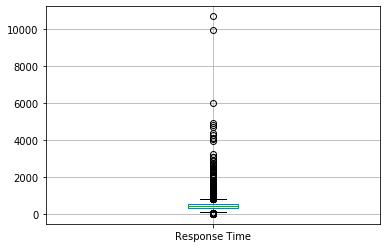

In [37]:
city_boxplot=city.boxplot(column=['Response Time'])

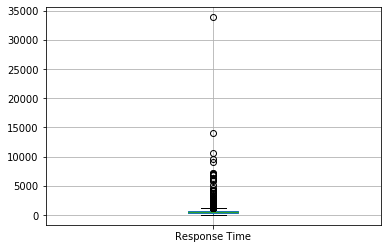

In [41]:
Subarb_boxplot=Subarb.boxplot(column=['Response Time'])

In [42]:
print(city['Response Time'].describe())

count     3009.000000
mean       514.404121
std        440.379572
min         23.000000
25%        366.000000
50%        438.000000
75%        545.000000
max      10711.000000
Name: Response Time, dtype: float64


In [43]:
print(Subarb['Response Time'].describe())

count     2831.000000
mean       677.346521
std        904.679907
min         22.000000
25%        434.000000
50%        549.000000
75%        725.000000
max      33883.000000
Name: Response Time, dtype: float64


## looking at comparison of feature importances for city vs subarb

In [16]:
test_Subarb = Subarb[Subarb['TOC'].dt.year == 2015]
train_Subarb=Subarb[Subarb['TOC'].dt.year != 2015]
test_city= city[city['TOC'].dt.year == 2015]
train_city=city[city['TOC'].dt.year != 2015]

In [17]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
Y_train_Subarb=train_Subarb['Response Time']
X_train_Subarb=train_Subarb.drop(columns=['Response Time','Date','TOC','IA'])
Y_test_Subarb=test_Subarb['Response Time']
X_test_Subarb=test_Subarb.drop(columns=['Response Time','Date','TOC','IA'])

In [18]:
Y_train_city=train_city['Response Time']
X_train_city=train_city.drop(columns=['Response Time','Date','TOC','IA'])
Y_test_city=test_city['Response Time']
X_test_city=test_city.drop(columns=['Response Time','Date','TOC','IA'])

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train_Subarb,Y_train_Subarb)
RF_predictions_Subarb = rf.predict(X_train_Subarb)
train_Subarb['RF Predictions']=RF_predictions_Subarb

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
RF_predictions_test_Subarb = rf.predict(X_test_Subarb)
test_Subarb['RF Predictions']=RF_predictions_test_Subarb
# Get numerical feature importances
Subarb_importances = list(rf.feature_importances_)
# List of tuples with variable and importance
Subarb_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X_train_Subarb.columns.values), Subarb_importances) if importance > 0.01]
# Sort the feature importances by most important first
Subarb_feature_importances = sorted(Subarb_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in Subarb_feature_importances];


Variable: Description_S/S FLOOD Importance: 0.07
Variable: Month_7              Importance: 0.07
Variable: Wind Speed           Importance: 0.06
Variable: Hour_17              Importance: 0.06
Variable: Hour_18              Importance: 0.06
Variable: Hour_20              Importance: 0.05
Variable: Precipitation        Importance: 0.04
Variable: Month_6              Importance: 0.04
Variable: Description_Fire SMALL Importance: 0.03
Variable: Hour_21              Importance: 0.03
Variable: Day_26               Importance: 0.03
Variable: Description_S/S OTHER Importance: 0.02
Variable: Hour_10              Importance: 0.02
Variable: Hour_13              Importance: 0.02
Variable: Hour_14              Importance: 0.02
Variable: Day_7                Importance: 0.02
Variable: Day_16               Importance: 0.02
Variable: Day_31               Importance: 0.02
Variable: Month_8              Importance: 0.02
Variable: Month_10             Importance: 0.02
Variable: Description_Fire CHIMNEY I

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
rf.fit(X_train_city,Y_train_city)
RF_predictions_city = rf.predict(X_train_city)
train_city['RF Predictions']=RF_predictions_city

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
RF_predictions_test_city = rf.predict(X_test_city)
test_city['RF Predictions']=RF_predictions_test_city
# Get numerical feature importances
city_importances = list(rf.feature_importances_)
# List of tuples with variable and importance
city_feature_importances = [(feature, round(importance, 2)) for feature,importance in zip(list(X_train_city.columns.values), city_importances)if importance > 0.01]
# Sort the feature importances by most important first
city_feature_importances = sorted(city_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in city_feature_importances];


Variable: Description_S/S FLOOD Importance: 0.17
Variable: Day_26               Importance: 0.1
Variable: Wind Speed           Importance: 0.06
Variable: Hour_17              Importance: 0.04
Variable: Precipitation        Importance: 0.03
Variable: Hour_2               Importance: 0.03
Variable: Hour_16              Importance: 0.03
Variable: Day_3                Importance: 0.03
Variable: Month_7              Importance: 0.03
Variable: Description_S/S MER  Importance: 0.02
Variable: Hour_18              Importance: 0.02
Variable: Hour_23              Importance: 0.02
Variable: Day_13               Importance: 0.02
Variable: Month_11             Importance: 0.02
Variable: Description_S/S MKSCSF Importance: 0.01
Variable: Hour_1               Importance: 0.01
Variable: Hour_21              Importance: 0.01
Variable: Day_7                Importance: 0.01
Variable: Day_15               Importance: 0.01
Variable: Day_25               Importance: 0.01
Variable: Day_28               Importa

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
city_feature_importances

[('Description_S/S FLOOD', 0.17),
 ('Day_26', 0.1),
 ('Wind Speed', 0.06),
 ('Hour_17', 0.04),
 ('Precipitation', 0.03),
 ('Hour_2', 0.03),
 ('Hour_16', 0.03),
 ('Day_3', 0.03),
 ('Month_7', 0.03),
 ('Description_S/S MER', 0.02),
 ('Hour_18', 0.02),
 ('Hour_23', 0.02),
 ('Day_13', 0.02),
 ('Month_11', 0.02),
 ('Description_S/S MKSCSF', 0.01),
 ('Hour_1', 0.01),
 ('Hour_21', 0.01),
 ('Day_7', 0.01),
 ('Day_15', 0.01),
 ('Day_25', 0.01),
 ('Day_28', 0.01)]

In [24]:
city_importances_graph = pd.DataFrame(city_feature_importances, columns = ['Feature','Importance'])
subarb_importances_graph=pd.DataFrame(Subarb_feature_importances, columns = ['Feature','Importance'])

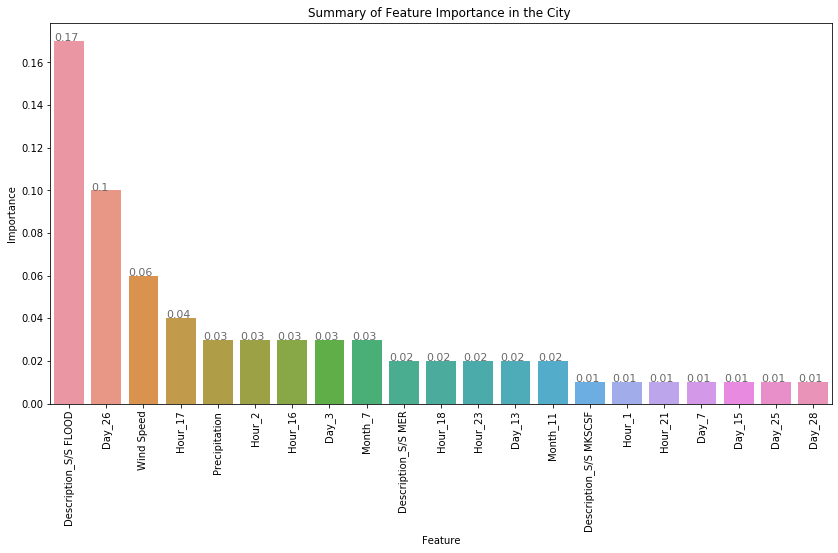

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Feature", y="Importance", data= city_importances_graph)
ax.set(ylabel="Importance",xlabel="Feature", title="Summary of Feature Importance in the City ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

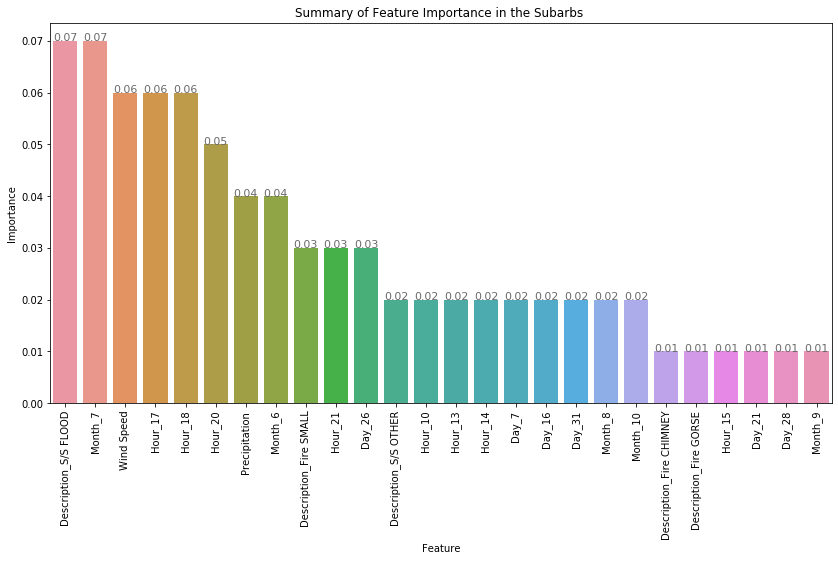

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Feature", y="Importance", data= subarb_importances_graph)
ax.set(ylabel="Importance",xlabel="Feature", title="Summary of Feature Importance in the Subarbs ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=90)

In [30]:
train_city.loc[train_city['Description_S/S FLOOD'] == 1]

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,RF Predictions
98,2013-01-04,2013-04-01 22:30:08,2013-04-01 22:37:07,419.0,0.0,16.4,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,435.140000
728,2013-01-29,2013-01-29 03:07:07,2013-01-29 03:20:46,819.0,0.1,28.2,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,711.810000
1012,2013-02-11,2013-11-02 13:51:52,2013-11-02 14:16:07,1455.0,0.4,11.2,0.0,0,0,0,...,0,0,0,0,0,0,0,1,0,1160.987143
1576,2013-03-03,2013-03-03 12:29:23,2013-03-03 12:35:50,387.0,0.0,12.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,569.550000
2346,2013-04-03,2013-03-04 14:26:35,2013-03-04 14:46:50,1215.0,0.0,16.1,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,976.620000
2446,2013-04-06,2013-06-04 10:37:21,2013-06-04 10:44:54,453.0,0.0,14.6,1.0,0,0,0,...,0,0,1,0,0,0,0,0,0,605.860000
2667,2013-04-14,2013-04-14 08:38:52,2013-04-14 09:05:27,1595.0,0.2,29.6,1.0,0,0,0,...,1,0,0,0,0,0,0,0,0,1219.830000
2858,2013-04-21,2013-04-21 19:11:15,2013-04-21 19:19:59,524.0,0.2,19.1,1.0,0,0,0,...,1,0,0,0,0,0,0,0,0,556.820000
3301,2013-05-08,2013-08-05 20:38:37,2013-08-05 20:49:10,633.0,0.3,25.2,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,664.460000
4123,2013-06-08,2013-08-06 14:53:38,2013-08-06 15:01:58,500.0,0.0,8.5,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,609.570000


In [32]:
train_Subarb.loc[train_Subarb['Description_S/S FLOOD'] == 1]

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,RF Predictions
262,2013-01-10,2013-10-01 00:24:51,2013-10-01 00:32:18,447.0,0.0,13.7,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,487.950000
643,2013-01-26,2013-01-26 02:38:53,2013-01-26 03:01:43,1370.0,0.3,23.5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1311.495000
729,2013-01-29,2013-01-29 03:24:59,2013-01-29 03:36:14,675.0,0.1,28.2,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,713.390000
823,2013-02-02,2013-02-02 20:33:25,2013-02-02 20:48:30,905.0,0.0,10.7,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,740.260000
2057,2013-03-22,2013-03-22 12:45:24,2013-03-22 12:52:54,450.0,0.8,23.7,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,621.635000
3802,2013-05-28,2013-05-28 02:55:38,2013-05-28 03:03:48,490.0,0.0,14.5,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,689.150000
3878,2013-05-31,2013-05-31 14:10:12,2013-05-31 14:19:30,558.0,0.0,11.9,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,720.110000
4425,2013-06-18,2013-06-18 21:56:24,2013-06-18 22:04:25,481.0,0.0,9.1,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,513.190000
4429,2013-06-19,2013-06-18 23:52:04,2013-06-19 00:03:24,680.0,0.0,10.5,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,626.280000
5855,2013-07-26,2013-07-26 18:09:01,2013-07-26 18:16:52,471.0,0.2,10.8,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,4845.160360
